In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [3]:
#loading data
df = pd.read_csv('telco_customer_churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df = df.drop(['customerID'], axis = 1)

df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [9]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

For now, i will either delete the na's or fill with the mean value. In the future i may try imputation using knn

Always try to understand the columns first

In [22]:
df[df.TotalCharges.isna()].tenure

488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

I will set the total charges == 0 where values are null, because these are people with 0 tenure. Therefore, the assumption is there have been no charges accrued yet

In [23]:
df.TotalCharges.sum()

16056168.7

In [24]:
df.TotalCharges.isna().sum()

11

In [25]:
# changing values to 0
df.loc[df.TotalCharges.isna(),'TotalCharges'] = 0

In [26]:
df.TotalCharges.sum()

16056168.7

In [27]:
df.TotalCharges.isna().sum()

0

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


map SeniorCitizen to categorical data for the sake of the next step. df.describe will take the numerical values

In [32]:
df.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [33]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'No',1:'Yes'})

In [34]:
df.SeniorCitizen.value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

In [35]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [39]:
df['Churn'] = df['Churn'].map({'No':0,'Yes':1})

In [40]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [43]:
df_dummies = pd.get_dummies(df)

<AxesSubplot:>

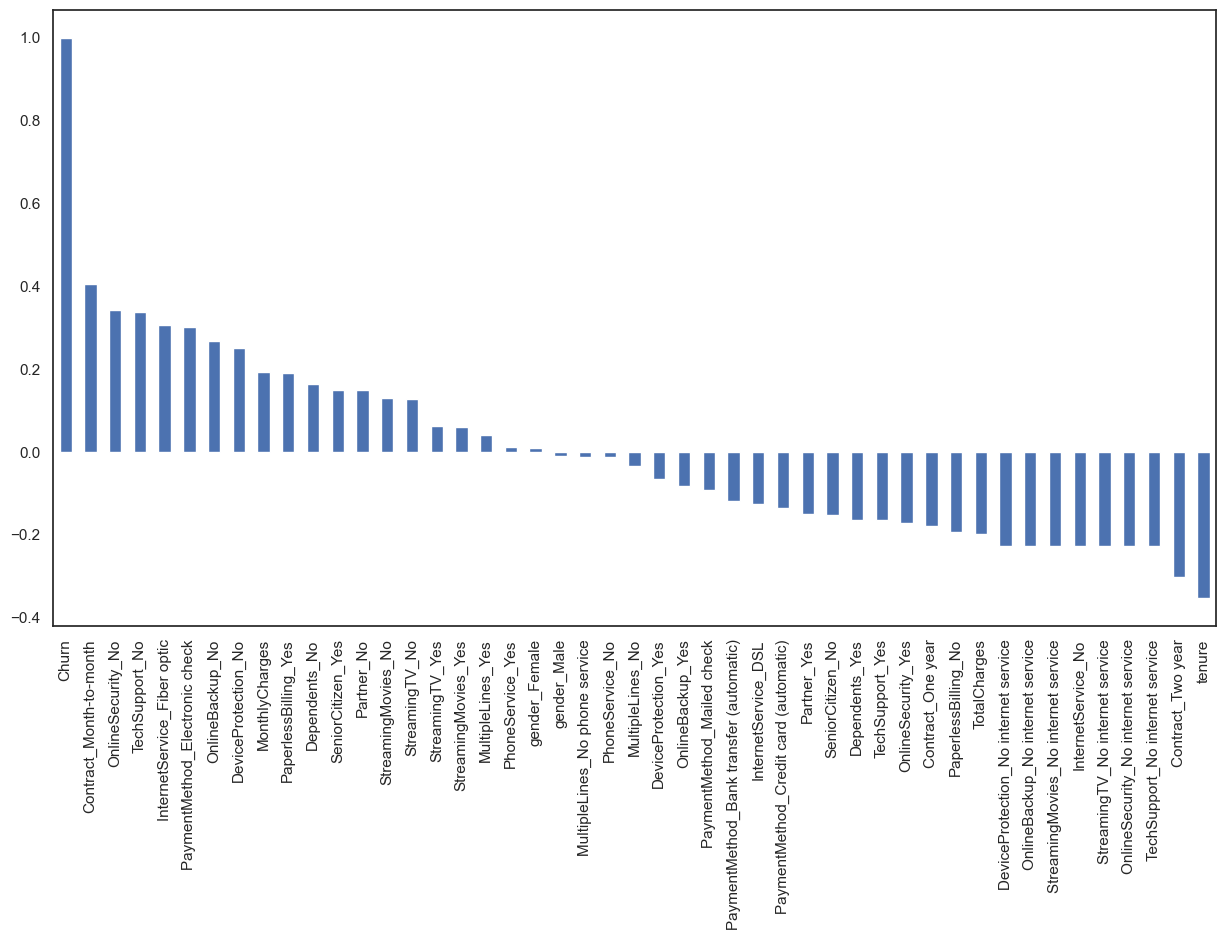

In [45]:
plt.figure(figsize=(15,8))
sns.set(style='white')

df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

<b>Rule of Thumb:<br></b>
corr > 0.4 strong<br>
0.2 <= corr <=0.4<br>
corr < 0.2 weak<br>
Negative correlation means as one rises the other goes down<br>
Positive correlation means as one rises so does the other<br>
Correlation ranges from -1 to 1<br>
In feature selection, variables should be highly correlated with the target, but uncorrelated among themselves. If they are too correlated amongst themselves, this could give us redundant variables.<br>
The central hypothesis of correlation feature selection is that good feature sets contain features that are highly correlated with the class, yet uncorrelated with each other.<br>
The Curse of Dimensionality<br>
Two features with high correlation could affect interpretability

In [50]:
corrmat = df_dummies.corr()

In [54]:
corrmat.iloc[0:5,0:5]

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female
tenure,1.000000,0.247900,0.826178,-0.352229,-0.005106
MonthlyCharges,0.247900,1.000000,0.651174,0.193356,0.014569
TotalCharges,0.826178,0.651174,1.000000,-0.198324,0.000080
Churn,-0.352229,0.193356,-0.198324,1.000000,0.008612
gender_Female,-0.005106,0.014569,0.000080,0.008612,1.000000


<AxesSubplot:>

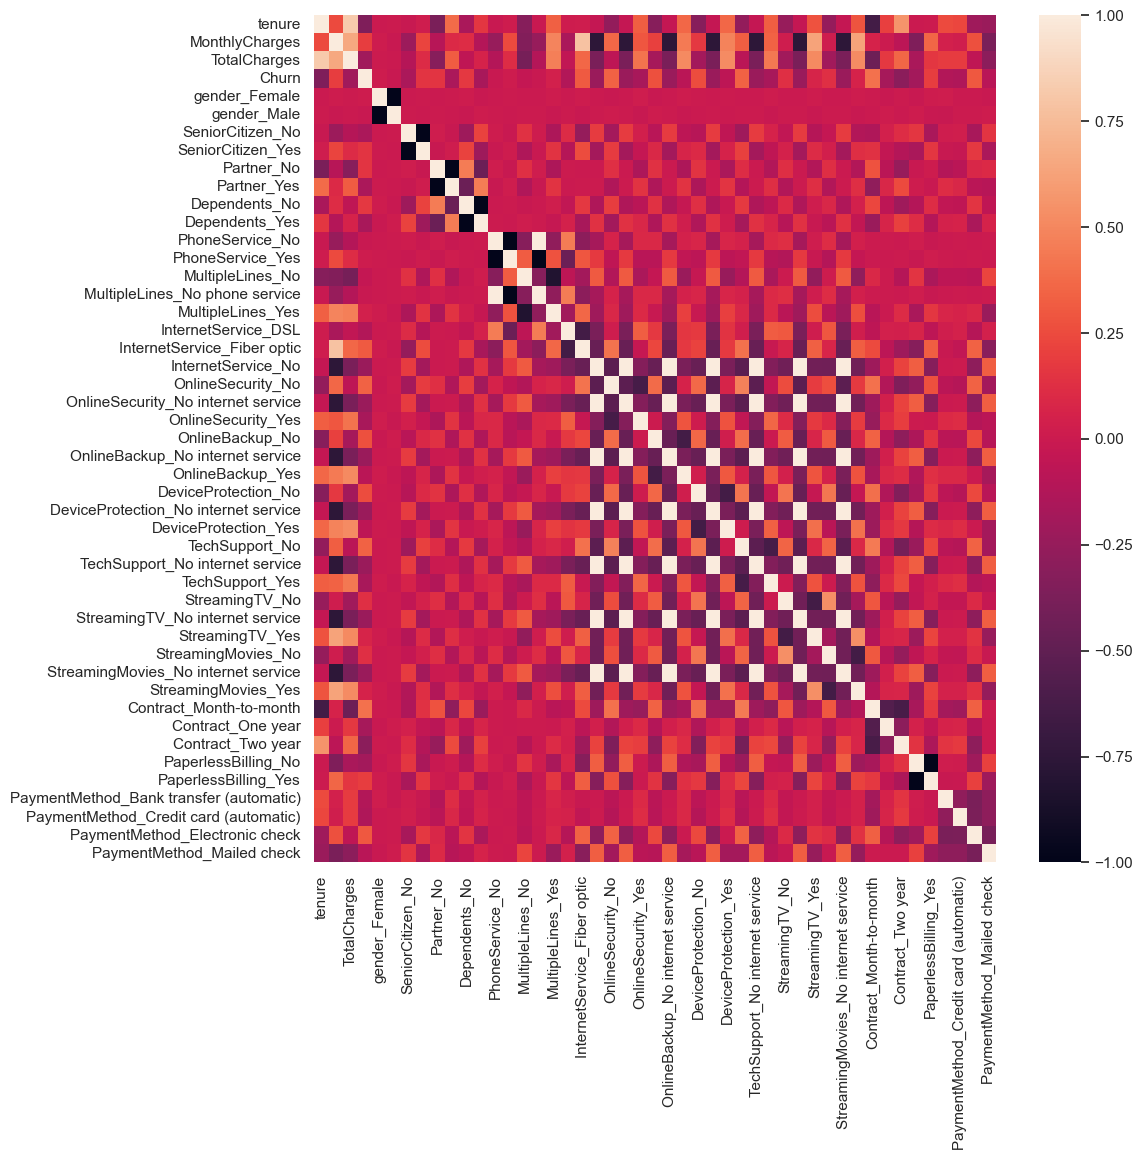

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)